In [67]:
import numpy as np
import random
import matplotlib.pyplot as plt
from numba import jit
from scipy.optimize import curve_fit

**Model definition**

In [5]:
@jit(nopython=True, fastmath=True)
def Brownian_motion(Nin, Nfin, dt, w, m):
    for j in range(Nin, Nfin):
        w[j+1]=w[j]+m*np.sqrt(dt)*np.random.randn()
    return w

In [14]:
@jit(nopython=True, fastmath=True)
def Polarized_motion(Nin, Nfin, dt, x, y, m, v0, phi): #change phi into theta +eta
    for j in range(Nin, Nfin):
        x[j+1]=x[j] + v0*np.cos(phi[j])*dt+m*np.sqrt(dt)*np.random.randn()
        y[j+1]=y[j] + v0*np.sin(phi[j])*dt+m*np.sqrt(dt)*np.random.randn()
    return x, y

In [15]:
@jit(nopython=True, fastmath=True)
def ForwardEuler_iso(nin, nfin, dt, ux, uy, alpha, m):
    for k in range(nin, nfin):
        
        tmp_theta = np.arctan2(uy[k],ux[k]);

        ux[k+1] = ux[k] + dt*(-alpha)*(ux[k] - np.cos(tmp_theta))+m*np.sqrt(dt)*np.random.randn()
        uy[k+1] = uy[k] + dt*(-alpha)*(uy[k] - np.sin(tmp_theta))+m*np.sqrt(dt)*np.random.randn()

    return ux, uy

In [16]:
@jit(nopython=True, fastmath=True)
def ForwardEuler_pol(nin, nfin, dt, ux, uy, m, p, alpha):
    
    for k in range(nin, nfin):
        ux[k+1]=ux[k]+dt*(-alpha)*(ux[k]+np.cos(p[k]))+m*np.sqrt(dt)*np.random.randn()
        uy[k+1]=uy[k]+dt*(-alpha)*(uy[k]+np.sin(p[k]))+m*np.sqrt(dt)*np.random.randn()
    return ux, uy

In [17]:
@jit(nopython=True, fastmath=True)
def theta_compute(Nin, Nfin, ux, uy, theta): #compute directly theta from arctan2 uy/ux without ex and ey
    
    for j in range(Nin, Nfin+1):      

        theta[j] = np.arctan2(uy[j], ux[j])
        
    return theta

**Portrait of a trajectory**
- MSD
- Correlation function
- Memory kernel

In [25]:
#@jit(nopython=True, fastmath=True)
def cvv_compute(N, X, Y, vx, vy, dt, end): 
  
    ## This function returns vacf and l == vector of time 
    for k in range(N):
        vx[k]=(X[k+1]-X[k])/dt
        vy[k]=(Y[k+1]-Y[k])/dt
    
    vXacf = np.fft.ifft(np.abs(np.fft.fft(vx[10000:]))**2)/len(vx)
    vYacf = np.fft.ifft(np.abs(np.fft.fft(vy[10000:]))**2)/len(vy)

    vXacf = np.real(vXacf[0:len(vXacf)//end])
    vYacf = np.real(vYacf[0:len(vYacf)//end])

    vacf = vXacf + vYacf
    
    l = np.arange(len(vacf))*dt
    #vacf = np.stack([l,vacf])
    
    return vacf, l 

In [26]:
#@jit(nopython=True, fastmath=True)
def msd_compute(N, X, Y):
    
    msd = np.zeros(N+1)
    
    for l in range(N+1):
        msd[l] = (X[0] - X[l])**2+(Y[0] - Y[l])**2
    return msd

In [27]:
#@jit(nopython=True, fastmath=True)
def Mem_kernel(Cvv, dt):
  ##Function which return g = Memory Kernel, G = integration of memory kernel
  nsamples = len(Cvv)-1

  G = np.zeros(nsamples)
  g = np.zeros(nsamples)
    
  G[0] = 2.*(Cvv[0]-Cvv[1])/(Cvv[0]+Cvv[1])
  for ii in range(1,nsamples):
    G[ii] = 2.*(Cvv[0]-Cvv[ii+1])/(Cvv[0] + Cvv[1])
    s = 0
    for jj in range(0,ii): 
      s = s + G[ii-(jj+1)]*(Cvv[jj+2] + Cvv[jj+1])/(Cvv[0] + Cvv[1])
    G[ii] = G[ii] - s

  # normalize
  G = G/dt
    
  # differentiate
  g[0] = 2*G[0]/dt
  g[1:] = np.diff(G)/dt;

  return G, g

In [65]:
@jit(nopython=True, fastmath=True)
def VACF_fit(x, v, a, b, c):
    return (v * np.exp(-a * x)*np.cos(b*x+c))

**Defining model parameters**

In [28]:
N  = 1000000
dt = 0.01

par_sigma = 0.1    #[sigma] = [min]$^{-1}$
par_lambda = 0.139 #[lambda]= [min]$^{-1}$

#Equilibrium distance of cell-cargo system 
l0= 18 #relative distance [l0]=[macrom]

#Diffusivity parameters:
D_iso = 1. #[D]=[macro m^2]/[min]
D_phi = 0.1 #[D_phi]=[min]^{-1}
Dp = 1 #[D]=[macro m^2]/[min]
D_delta = 0.04 #[D_delta] = [min]^-1

#Parameters describing the elastic interaction within the cell-cargo couple
alpha = 2. #[alpha] = [min]^-1

#Cells' mean velocity: 
v0=6 #[v0]=[macro m]/[min]

#INITIAL CONDITION
x0 = 0.
y0 = 0.

ux0 = 1.
uy0 = 0.

**Defining my trajectory class**

In [29]:
class one_traj:
    
    def __init__(self, N, dt, par_sigma, par_lambda, l0, D_iso, D_phi, Dp, D_delta, alpha, v0, x0, y0, ux0, uy0):    
        
        # define the characteristics of the trajectory       
        self.x =  np.zeros(N+1)
        self.y =  np.zeros(N+1)
        self.ux = np.zeros(N+1)
        self.uy = np.zeros(N+1)
        self.X =  np.zeros(N+1)
        self.Y =  np.zeros(N+1)
        self.vx =  np.zeros(N+1)
        self.vy =  np.zeros(N+1)

        self.phi =  np.zeros(N+1)
        self.theta =  np.zeros(N+1)
        
        self.time = np.arange(0,(N+1)*dt, dt)
                            
        self.relx = np.zeros(N+1)
        self.rely = np.zeros(N+1)
        self.relabs = np.zeros(N+1)
    
        # save the parameters
        self.par_sigma  = par_sigma;
        self.par_lambda = par_lambda;
        
        self.P = self.par_lambda/(self.par_lambda + self.par_sigma)

        self.N  = N
        self.dt = dt
        
        self.l0 = l0
    
        self.D_iso = D_iso
        self.D_phi = D_phi
        self.Dp = Dp
        self.D_delta = D_delta
   
        self.k_phi = np.sqrt(2*self.D_phi)
        self.k     = np.sqrt(2*self.D_iso)
        self.k_pol = np.sqrt(2*self.Dp)
        self.k_delta = np.sqrt(2*self.D_delta)
        
        self.alpha = alpha
               
        self.v0 = v0
        
        # save the initial condition
        self.x0 = x0
        self.y0 = y0
                
        self.ux0 = ux0
        self.uy0 = uy0

        # make a clock with the current parameter values
        self.__CreateClock()    
        
        # create the trajectory - solve the dynamics
        self.__SolveDynamics()
            
    def __GetIsotropicTime(self):

        t = -1/self.par_lambda * np.log(np.random.rand())
        t = int(t/self.dt)                                    

        while t == 0:
            t = -1/self.par_lambda * np.log(np.random.rand())
            t = int(t/self.dt)                                    
            
        return t
        
    def __GetPolarTime(self):
        
        t1 = -1/(self.par_lambda+self.par_sigma) * np.log(np.random.rand())
        t1 = int(t1/self.dt)  

        while t1 == 0:
            t1 = -1/(self.par_lambda+self.par_sigma) * np.log(np.random.rand())
            t1 = int(t1/self.dt)  
            
        return t1
    
    def PrintInitialCondition(self):
        
        print('(x0,y0)   = (%f,%f)' % (self.x0, self.y0))
        print('(ux0,uy0) = (%f,%f)' % (self.ux0,self.uy0))
    
    def __CreateClock(self):
  
        N_list = [0]
        state_list = []

        t = self.__GetIsotropicTime()
        
        N_list.append(t + N_list[-1])
        state_list.append('I')

        t1 = self.__GetPolarTime()
        
        N_list.append(t1 + N_list[-1])
        state_list.append('P')

#         TotalIso = t;
#         TotalPol = t1;
# 
#         nIsoEpisodes = 1;
#         nPolEpisodes = 1;

        while N_list[-1] < N:
          
            if state_list[-1] == 'I':

                # you must go to state P
                t1 = self.__GetPolarTime()
                
                N_list.append(t1 + N_list[-1])
                state_list.append('P')

#                TotalPol = TotalPol + t1
#                nPolEpisodes = nPolEpisodes + 1

            # state_list[-1] == 'P' 
            else: 

                if self.P > np.random.rand():
                    
                    t1 = self.__GetPolarTime()
                                            
                    N_list.append(t1 + N_list[-1])
                    state_list.append('P')

#                    TotalPol = TotalPol + t1
#                    nPolEpisodes = nPolEpisodes + 1
              
                else:
                    
                    t = self.__GetIsotropicTime()
                    
                    N_list.append(t + N_list[-1])
                    state_list.append('I')

#                     TotalIso = TotalIso + t
#                     nIsoEpisodes = nIsoEpisodes + 1

        N_list[-1] = N
        states = list(zip(zip(N_list[:-1],N_list[1:]),state_list))
        #print(states)
        
        # save for later use
        self.N_list = N_list
        self.states = states

    def __SolveDynamics(self):

        # set the initial condition
        self.x[0] = self.x0
        self.y[0] = self.y0
        
        self.ux[0] = self.ux0
        self.uy[0] = self.uy0
        
        # solve the main dynamics
        for (Nin, Nfin), state in self.states:
            
            if state == 'I':
                
                self.x = Brownian_motion(Nin, Nfin, self.dt, self.x, self.k)
                self.y = Brownian_motion(Nin, Nfin, self.dt, self.y, self.k)
                
                self.ux, self.uy= ForwardEuler_iso(Nin, Nfin, self.dt, self.ux, self.uy, self.alpha, self.k_delta)
                
            if state == 'P':
                
                self.phi[Nin] = self.theta[Nin] + np.random.normal(0,0.2)
                
                self.phi = Brownian_motion(Nin, Nfin, self.dt, self.phi, self.k_phi)
                
                self.x, self.y = Polarized_motion(Nin, Nfin, self.dt, self.x, self.y, self.k_pol, self.v0, self.phi)
                
                self.ux, self.uy = ForwardEuler_pol(Nin, Nfin, self.dt, self.ux, self.uy, self.k_delta, self.phi, self.alpha)

            # update the theta-values
            self.theta = theta_compute(Nin, Nfin, self.ux, self.uy, self.theta)
            
        # calculate the corresponding dynamics of the cargo
        self.X = self.x + self.l0 * self.ux
        self.Y = self.y + self.l0 * self.uy

        # calculate the relative dynamics    
        self.relx = self.X - self.x
        self.rely = self.Y - self.y
        
        self.relabs = np.sqrt(self.relx**2 + self.rely**2)
        
    def PlotCellMotion(self):
        
        fig,ax = plt.subplots(figsize=(7, 8))
        ax.set_ylabel('y(t) [$\mu$m]', fontsize=14)
        ax.set_xlabel('x(t) [$\mu$m]', fontsize=14)
        ax.set_title('Motion of the cell', fontsize=18)
        ax.grid()
        ax.plot(self.x,self.y)        
        plt.show()

    def PlotRelativeMotion(self):
                
        fig,ax = plt.subplots(figsize=(7, 7))
        ax.set_ylabel('$y(t)-Y(t)$ [$\mu$m]', fontsize=14)
        ax.set_xlabel('$x(t)-X(t)$ [$\mu$m]', fontsize=14)
        ax.set_title('Trajectory of the cargo around the cell', fontsize=18)
        ax.grid()
        ax.plot(self.relx,self.rely)
        plt.show()        

    def PlotRelativeMotionStats(self):
                
        fig,ax = plt.subplots(figsize=(7, 7))
        ax.set_ylabel('$ |r(t) - R(t)| $ [$\mu$m]', fontsize=14)
        ax.set_xlabel('$t$ [min]', fontsize=14)
        ax.set_title('Trajectory of the cargo around the cell', fontsize=18)
        ax.grid()
        ax.plot(self.time, self.relabs, alpha = 0.8)
        plt.show()

        fig,ax = plt.subplots(figsize=(7, 7))
        ax.set_ylabel('PDF', fontsize=14)
        ax.set_xlabel('$ |r(t) - R(t)| $ [$\mu$m]', fontsize=14)
        ax.set_title('Histogram of relative distance', fontsize=18)
        ax.grid(axis='y', alpha=0.75)
        ax.hist(self.relabs, bins=30,density = True, rwidth=0.85)
        plt.show()
    
        
        

**Create nT trajectories**

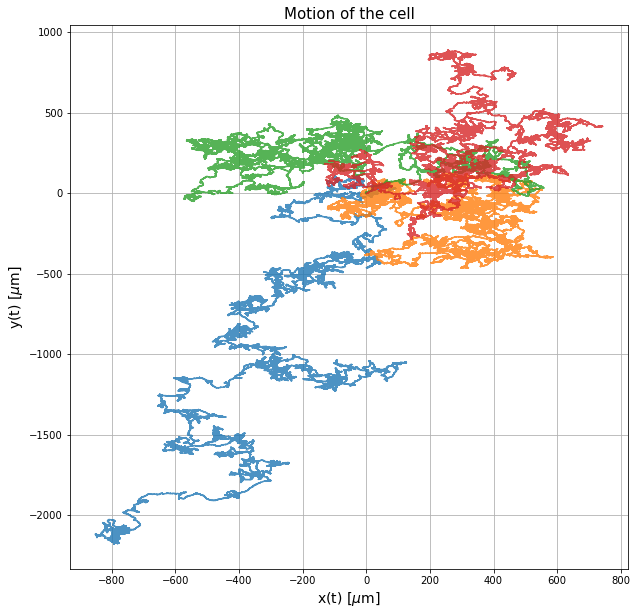

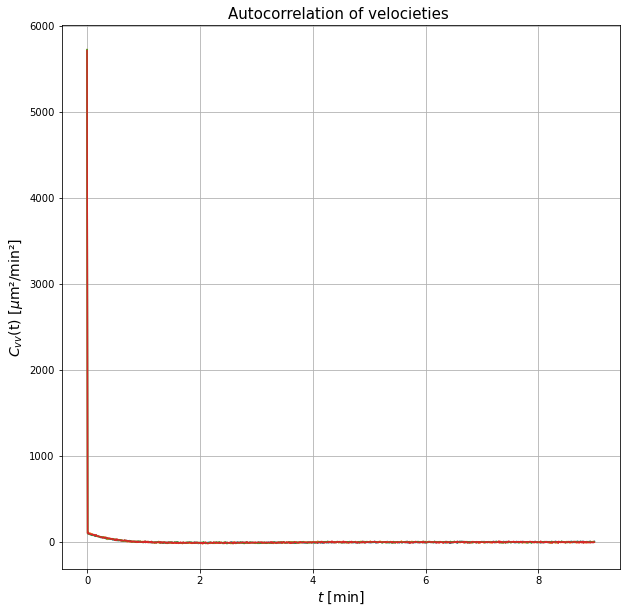

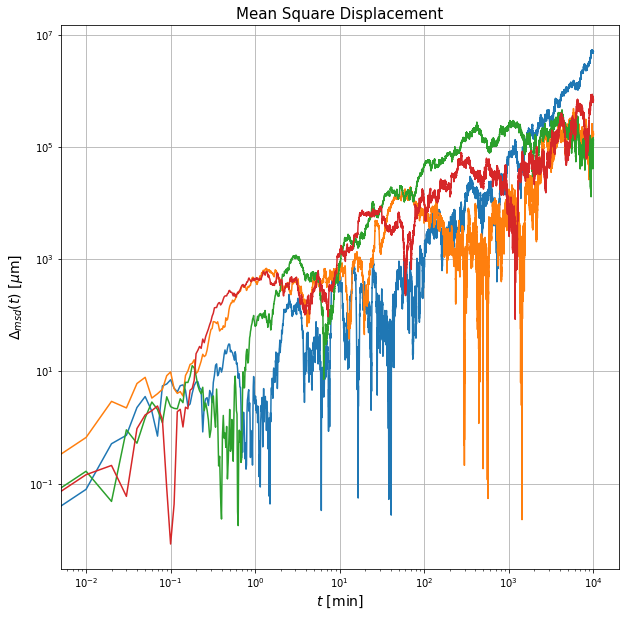

In [58]:
pList = [];
vacf_list = []
l_list =[]
msd_list = []

##Fig details ##
fig,ax = plt.subplots(figsize=(10, 10))
ax.set_ylabel('y(t) [$\mu$m]', fontsize=14)
ax.set_xlabel('x(t) [$\mu$m]', fontsize=14)
ax.set_title('Motion of the cell', fontsize=15)
ax.grid()


fig,ax1 = plt.subplots(figsize=(10, 10))
ax1.set_ylabel('$C_{vv}$(t) [$\mu$m²/min²]', fontsize=14)
ax1.set_xlabel('$t$ [min]', fontsize=14)
ax1.set_title('Autocorrelation of velocieties ', fontsize=15)
ax1.grid()

fig,ax2 = plt.subplots(figsize=(10, 10))
ax2.set_ylabel('$\Delta_{msd}(t)$ [$\mu$m]', fontsize=14)
ax2.set_xlabel('$t$ [min]', fontsize=14)
ax2.set_title('Mean Square Displacement', fontsize=15)
ax2.grid()

##N. of trajectories
nT = 4



for i in range(0,nT):
    pk = one_traj(N, dt, par_sigma, par_lambda, l0, D_iso, D_phi, Dp, D_delta, alpha, v0, x0, y0, ux0, uy0 )   
    pList.append(pk)
    ax.plot(pk.x, pk.y, alpha=0.8)
    vacf, l = cvv_compute(pk.N, pk.X, pk.Y, pk.vx, pk.vy, pk.dt, 60)
    vacf_list.append(vacf)
    l_list.append(l)
    ax1.plot(l[0:900],vacf[0:900]) 
    msd = msd_compute(pk.N, pk.X, pk.Y)
    msd_list.append(msd)
    ax2.loglog(pk.time, msd)
    
    

In [59]:
msd_np = np.asarray(msd_list)
vacf_np = np.asarray(vacf_list)

In [60]:
mean_msd = np.mean(msd_np, axis = 0)
mean_vacf = np.mean(vacf_np, axis = 0)
t_dummy = np.arange(len(mean_msd))*dt

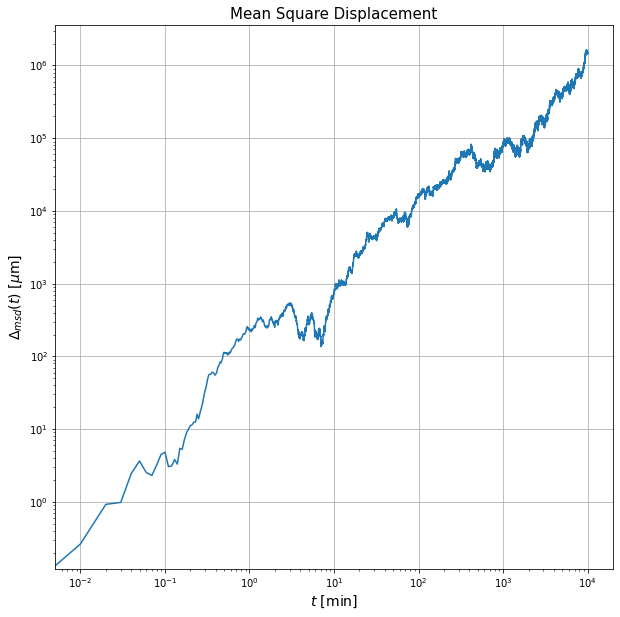

In [61]:
fig,ax = plt.subplots(figsize=(10, 10))
ax.set_ylabel('$\Delta_{msd}(t)$ [$\mu$m]', fontsize=14)
ax.set_xlabel('$t$ [min]', fontsize=14)
ax.set_title('Mean Square Displacement', fontsize=15)
ax.grid()
ax.loglog(t_dummy, mean_msd)

plt.show()


**Smoothing the delta peak**

In [62]:
tt = np.arange(len(mean_vacf))*dt
p = np.polyfit(tt[1:100], mean_vacf[1:100], 5)
print(p)
cFuncAct = np.polyval(p,0)
print(cFuncAct)
cDeltaInf = mean_vacf[0] - cFuncAct;
print(cDeltaInf)
mean_vacf[0]  = cFuncAct
print(mean_vacf[0:100])

[  29.45417331  -56.59339361   -2.44202387  149.32535843 -223.48244137
  104.95462961]
104.95462961242139
5611.277573338141
[104.95462961 101.84303711 102.30298777  98.06362403  97.07190688
  92.9979767   93.28975807  88.62027966  87.1119885   84.4371336
  86.29649373  82.32972301  78.59093142  80.20889592  76.04815598
  73.1892721   77.65938647  71.96091096  67.53220752  67.03898074
  66.60798231  64.04008687  62.96553107  59.84433342  57.49940416
  58.77254922  57.50648247  53.49310763  52.88299332  53.38094733
  55.4361737   46.99769516  47.50975017  51.50833505  44.36914792
  45.57743334  40.82901716  41.85627628  41.07843097  38.94360238
  40.51211237  36.90456424  33.51555927  33.69020668  36.72327018
  29.8857121   34.3392153   30.37516224  30.75587656  24.01891063
  25.9837182   27.06380946  22.16421566  28.68576497  22.80605987
  20.72015328  23.0110694   22.13875218  22.00908593  20.51550784
  19.00610029  18.04581625  17.22538457  15.06289287  15.34731592
  13.3388272   17.5

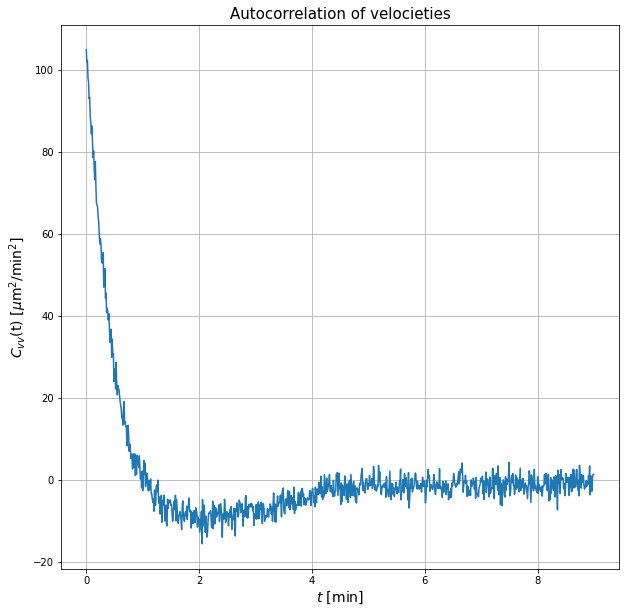

In [63]:
fig,ax = plt.subplots(figsize=(10, 10))
ax.set_ylabel('$C_{vv}$(t) [$\mu$m$^{2}$/min$^{2}$]', fontsize=14)
ax.set_xlabel('$t$ [min]', fontsize=14)
ax.set_title('Autocorrelation of velocieties', fontsize=15)
ax.grid()

ax.plot(tt[0:900], mean_vacf[0:900])
plt.show()


**Memory Kernel Analysis**

In [64]:
fit_cvv = mean_vacf[0:900]
fit_t = tt[0:900]

In [68]:
popt, pcov = curve_fit(VACF_fit, fit_t, fit_cvv, maxfev=10000) 
print(popt, pcov)

[4.52744625e+04 1.14400184e+00 2.23569213e-03 1.56852600e+00] [[ 3.25943740e+15  1.31633327e+05 -1.61787530e+08  1.64293645e+08]
 [ 1.31633327e+05  8.05400450e-05 -6.53371456e-03  6.63498364e-03]
 [-1.61787530e+08 -6.53371456e-03  8.03058987e+00 -8.15498498e+00]
 [ 1.64293645e+08  6.63498364e-03 -8.15498498e+00  8.28130698e+00]]


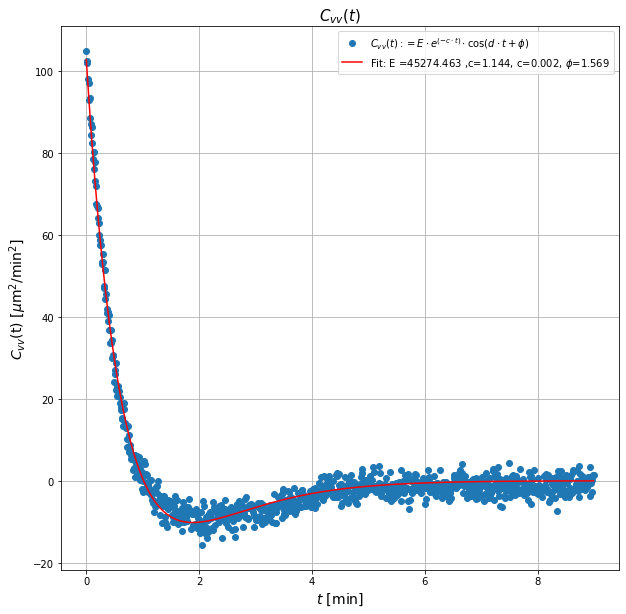

In [79]:
fig,ax = plt.subplots(figsize=(10, 10))
ax.set_ylabel('$C_{vv}$(t) [$\mu$m$^2$/min$^2$]', fontsize=14)
ax.set_xlabel('$t$ [min]', fontsize=14)
ax.set_title('$C_{vv}(t)$', fontsize=15)
ax.grid()
ax.plot(fit_t, fit_cvv, 'o', label="$C_{vv}(t):= E \cdot e^{(-c \cdot t)} \cdot \cos(d \cdot t+\phi) $")
ax.plot(fit_t, VACF_fit(fit_t, *popt), 'r-', label='Fit: E =%5.3f ,c=%5.3f, c=%5.3f, $\phi$=%5.3f' % tuple(popt))
plt.legend()

plt.show()

In [70]:
v, a, b, c= popt
tt = np.arange(5000)*dt
sin_cvv = VACF_fit(tt, v, a, b, c)

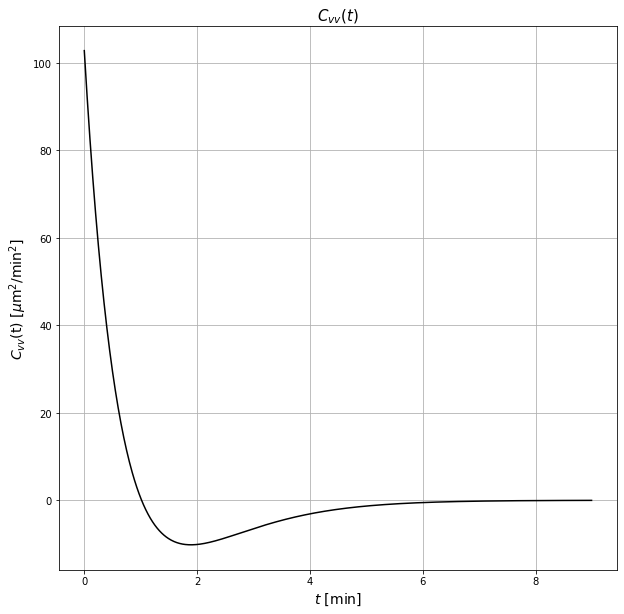

In [80]:
fig,ax = plt.subplots(figsize=(10, 10))
ax.set_ylabel('$C_{vv}$(t) [$\mu$m$^2$/min$^2$]', fontsize=14)
ax.set_xlabel('$t$ [min]', fontsize=14)
ax.set_title('$C_{vv}(t)$', fontsize=15)
ax.grid()
ax.plot(tt[0:900], sin_cvv[0:900], 'k-')
#plt.savefig('cvv_sin.png')
plt.show()

In [72]:
G, K = Mem_kernel(sin_cvv, dt)

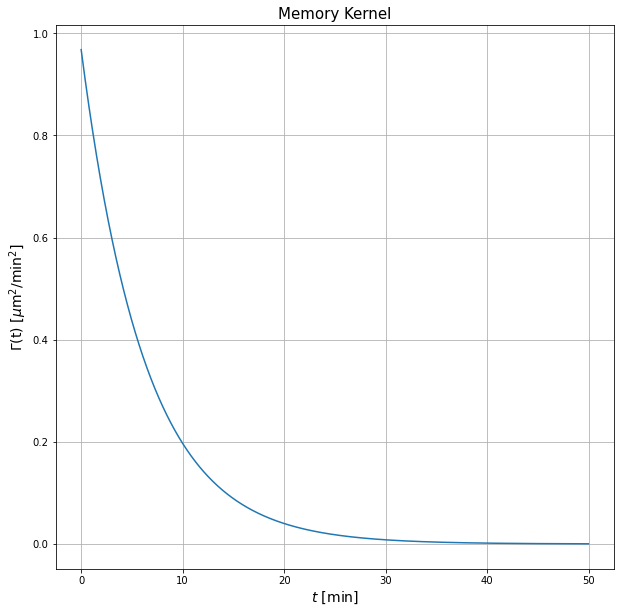

In [81]:
fig,ax = plt.subplots(figsize=(10, 10))
ax.set_ylabel('$\Gamma$(t) [$\mu$m$^2$/min$^2$]', fontsize=14)
ax.set_xlabel('$t$ [min]', fontsize=14)
ax.set_title('Memory Kernel', fontsize=15)
ax.grid()
ax.plot(np.arange(len(K[1:]))*dt, K[1:])


#plt.savefig('kernel1_fit.png')
plt.show()

**Playing around with the code: et one trajectory from the list**

In [74]:
p = pList[1]

**Show Initial conditions**

In [76]:
p.PrintInitialCondition()

(x0,y0)   = (0.000000,0.000000)
(ux0,uy0) = (1.000000,0.000000)


**Show the cell motion**

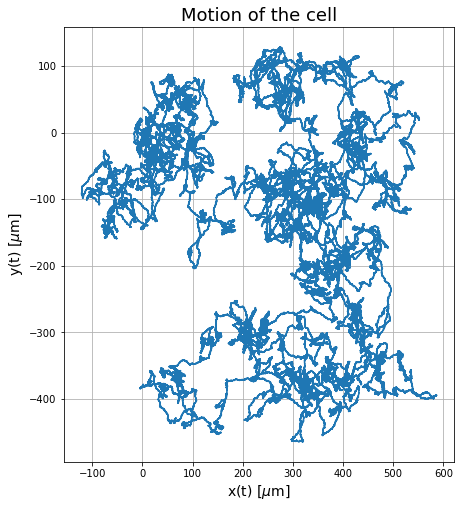

In [77]:
p.PlotCellMotion()

**Plot the relative dynamics**

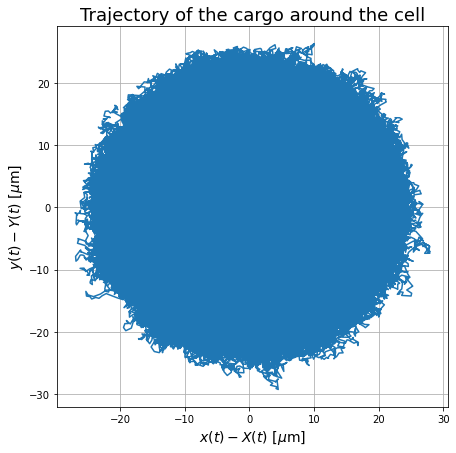

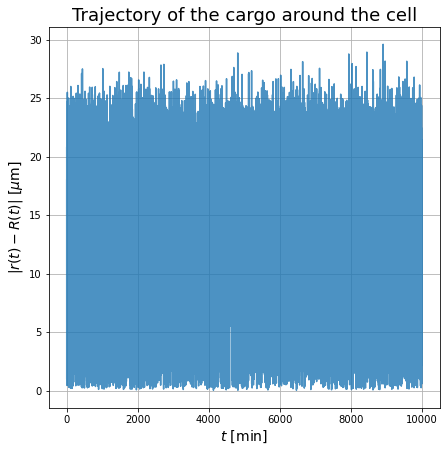

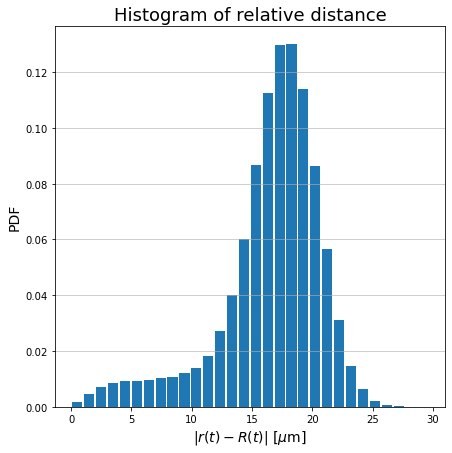

In [78]:
p.PlotRelativeMotion()
p.PlotRelativeMotionStats()